<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Разделение-на-train,-test" data-toc-modified-id="Разделение-на-train,-test-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Разделение на train, test</a></span></li><li><span><a href="#Fit-MyDecisionTree" data-toc-modified-id="Fit-MyDecisionTree-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fit MyDecisionTree</a></span></li><li><span><a href="#Predict-MyDecisionTree" data-toc-modified-id="Predict-MyDecisionTree-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Predict MyDecisionTree</a></span></li><li><span><a href="#Train-with-sklearn" data-toc-modified-id="Train-with-sklearn-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train with sklearn</a></span></li><li><span><a href="#Сравнение-метрик" data-toc-modified-id="Сравнение-метрик-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Сравнение метрик</a></span></li></ul></div>

# Задание  

1. Напишите свой алгоритм построения дерева решений для задачи бинарной классификации.  
    - критерий информативности - Энтропия Шеннона
    - критерии останова - максимальная глубина, кол-во элементов в листе, прирост энтропии < x
2. Сравните результат работы своего алгоритма с sklearn    

3. (дополнительно)  Попробуйте не делать One-Hot-Encoding для категориальных переменных, а добавить их обработку в свой алгоритм. Сравните качество работы алгоритма с предыдущим решением.

## Подготовка данных
Рассмотрим задачу "Титаник" https://www.kaggle.com/c/titanic/data. Необходимо предсказать выживет пассажир или нет.

In [ ]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix 

In [ ]:
# считаем данные из файла в pandas DataFrame
df = pd.read_csv("train.csv")

# зафиксируем целевую переменную и удалим ее из данных
y = df['Survived']
df.drop('Survived', axis=1, inplace=True)

In [ ]:
# удалим признаки PassengerId, Name, Ticket и Cabin из данных
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# заполним пропуски в признаке Age обучающей выборки медианным значением
df['Age'].fillna(df['Age'].median(), inplace=True)

#заполним пропуски в признаке Embarked обучающей выборки самыми частыми значениями этого признака
df['Embarked'].fillna(df['Embarked'].value_counts().idxmax(), inplace=True)

#заменим категориальные признаки, используя One-Hot-Encoding
categorical = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
df = pd.concat([df, pd.get_dummies(df[categorical], columns=categorical, drop_first=True)],axis=1)

df.drop(categorical, axis=1, inplace=True)

## Разделение на train, test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.1, random_state = 13)

In [ ]:
print ('Train: ' + str(len(X_train)))
print ('Test: ' + str(len(X_test)))

Train: 801
Test: 90


## Fit MyDecisionTree  
Напишите свою функцию построения дерева.

Структуру дерева можно задать, например, словарем следующего вида:  
```python
{'feature_name': 'Age', # название фичи 
'threshold': 20, # порог разбиения
'left': 0,  # ссылка на левое поддерево, задан доминирующий класс
'right': 1} # ссылка на правое поддерево, задан доминирующий класс
```

In [ ]:
def get_target(df):
  
    # YOUR CODE HERE
    return int(df.mode().values)


def get_entropy(target):

    count_uniq = np.unique(target, return_counts=True)[1]
    p = count_uniq/np.sum(count_uniq)
    S = float(-np.sum(p * np.log2(p)))
     
    entropy = S
    
    return entropy



def feature_separation(df, f_name):
  risk = []
  ig1 = []
  one_data = df    
  one_data = one_data.sort_values(f_name)

  s0 = get_entropy(one_data['Survived'])
  ind = np.unique(one_data[f_name], return_index = True)[1]
  one_data.index = np.arange(len(one_data))


  for i in range(0,len(ind)): 
    riska = one_data[f_name][ind[i]]
    risk.append(riska)
    if i != (len(ind) - 1):
      left = one_data[0 : ind[i+1]]
        
      right = one_data[ind[i+1] :]


    else:
        
      right = one_data[ind[i] :]
      left = one_data[0: ind[i]] 
  
    s1 = get_entropy(left["Survived"])
  
    s2 = get_entropy(right["Survived"])
    ig = s0 - len(left)*s1/len(one_data['Survived']) - len(right)*s2/len(one_data['Survived'])
    
    ig1.append(ig)
  new_pd = pd.DataFrame({'ig':ig1,'riska':risk})

  ig_max = new_pd['ig'].max()
  
  ind_ig_max = new_pd[['ig']].idxmax()
  delta_entropy = ig_max
  threshold = new_pd['riska'][ind_ig_max].values[0]
    
  return (delta_entropy, threshold)


def best_separation(df):
    """
        Функция выбирает фичу для разбиения, которая даст максимальный прирост энтропии.
        Input - исходный DataFrame
        
        Output - словарь следующиего вида
        {'feature_name': sep_feature, 'threshold': threshold, 'groups': groups}
        
            sep_feature - название фичи для разбиения (тип - String)
            threshold - порог разбиения (тип - float)
            groups - tuple из двух поддеревьев (df_left, df_right)
    """
    
    sep_feature, threshold, groups = None, None, df
    print(df)
    all_features = [c for c in df.columns.tolist() if c != 'target']
    delta_mass = []
    thres_mass = []
    
    for f in all_features:
        delta , threshold = feature_separation(df, f)
        delta_mass.append(delta)
        thres_mass.append(threshold)
    new_pd = pd.DataFrame({'feature':all_features,'delta':delta_mass,'threshold':thres_mass})           
   
    max_index = new_pd['delta'].idxmax()
    max_thres = new_pd['threshold'][max_index]
    max_feature = new_pd['feature'][max_index]
    
    threshold = max_thres
    
    sep_feature = df[max_feature].sort_values()
    df_right = pd.DataFrame()
    df_left = pd.DataFrame()
    
    df_left = df.loc[df[max_feature] <= threshold]
    df_right = df.loc[df[max_feature] > threshold]
    
   
    dict_lr = {'left':df_left,'right':df_right}
    return {'feature_name': f, 'threshold': threshold, 'groups': dict_lr}


def split(node, max_depth, depth):
    """
        Рекурсивная функция для построения дерева
        Input - node: корень дерева
                max_depth: максимальная глубина дерева
                depth: текущая глубина дерева"""
  
    
    df_left = node['groups']['left']    
    df_right = node['groups']['right']

    sep_feature = node['feature_name']   
    del(node['groups'])
    
    # проверяем, есть ли разбиение
    if len(df_left) == 0 or len(df_right) == 0:
        node['left'] = node['right'] = 0
        return
    
    # проверяем максимальную глубину
    if depth >= max_depth:
        
        node['left'] = get_target(df_left['Survived'])
        node['right'] = get_target(df_right['Survived'])
        return
    
    else:        
        node['left'] = best_separation(df_left)
        split(node['left'], max_depth, depth + 1)
      
        node['right'] = best_separation(df_right)
        split(node['right'], max_depth, depth + 1)
        
        
def fit_my_tree(df,  max_depth):
    """
        Функция для обучения дерева
        Input - df: DataFrame
                max_depth: максимальная глубина дерева
    """    
    root = best_separation(df)
    split(root, max_depth, 1)

    return root

In [ ]:
data = pd.concat([X_train, y_train], axis=1)
my_tree = fit_my_tree(data, 3)

## Predict MyDecisionTree  

In [ ]:
def predict_raw(row, tree):
    """
        Функция предсказывает класс для 1 строки DataFrame.
        
        Input - row: строка DataFrame
                tree: обученное дерево на предыдущем шаге (тип - dict)
    """    
    if row[tree['feature_name']] <= tree['threshold']:
        if type(tree['left']) == dict:
            return predict_raw(row, tree['left'])
        else:
            return tree['left']
    else:
        if type(tree['right']) == dict:
            return predict_raw(row, tree['right'])
        else:
            return tree['right']
    
    
def predict_my_tree(df, tree):
    """
        Функция предсказывает класс для исходного DataFrame.
        
        Input - df: исходный DataFrame
                tree: обученное дерево на предыдущем шаге (тип - dict)
                
        Output - предсказанные классы (тип - pandas.core.series.Series)
    """      
    predict = pd.Series()   
    for index, row in df.iterrows():
        prediction = pd.Series(predict_raw(row, tree), [index])
        predict = predict.append(prediction)    
        
    return predict

In [ ]:
data1 = pd.concat([X_test, y_test], axis=1)
my_tree1 = fit_my_tree(data1, 3)
my_pred_test = predict_my_tree(data1, my_tree1)
my_pred_train = predict_my_tree(data, my_tree)

print(my_pred_test)

## Train with sklearn 

Обучите дерево, используя библиотеку sklearn. Задайте те же параметры, что и при обучении своего дерева.  

Сравните метрики и попробуйте улучшить ваше дерево.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [ ]:
clf_tree = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=4)

# обучаем дерево
clf_tree.fit(X_train, y_train)

# предсказание на тестовой и обучающей выборках
y_pred_test = clf_tree.predict(X_test)
y_pred_train = clf_tree.predict(X_train)


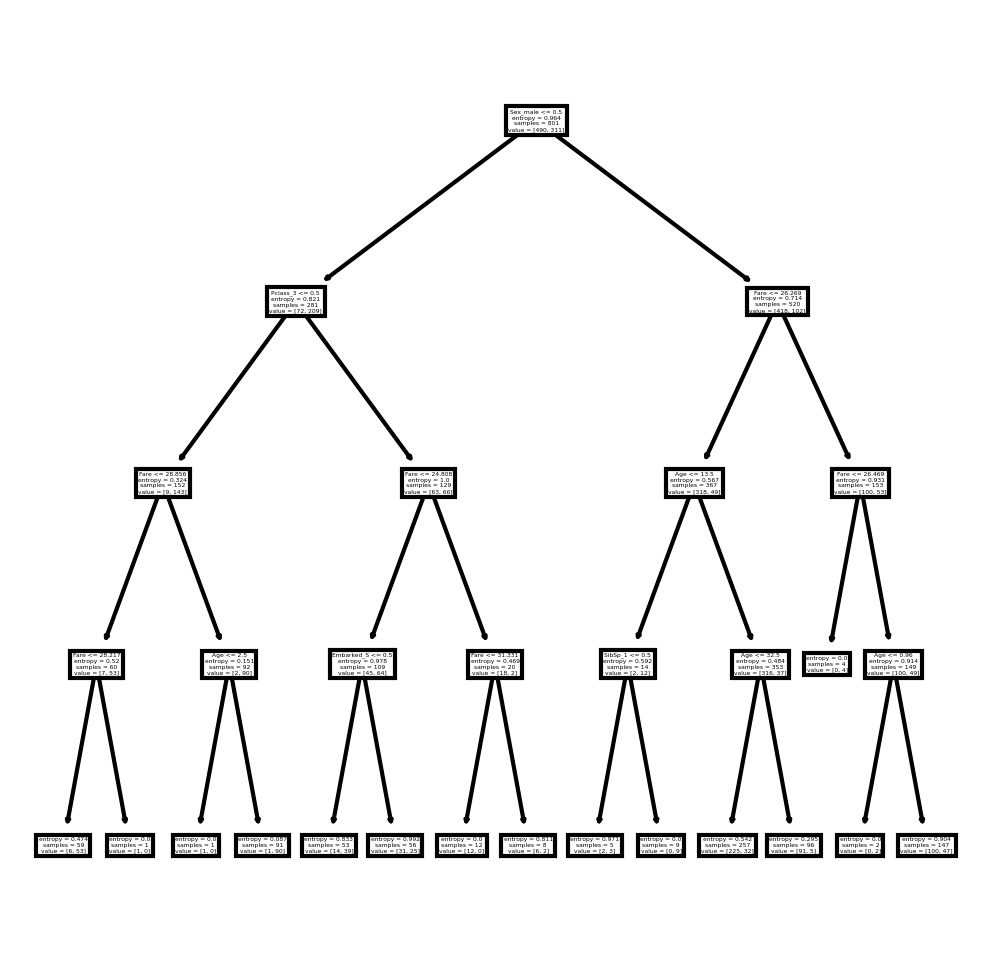

In [ ]:
#Отрисовать дерево можно вот так:  
from sklearn import tree 
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf_tree, feature_names = X_train.columns);

## Сравнение метрик

In [ ]:
# метрики при обучении, используя библиотеку sklearn
skl_roc_train = roc_auc_score(y_train, y_pred_train)
skl_roc_test = roc_auc_score(y_test, y_pred_test)

# метрики при обучении, используя собственный алгоритм
my_roc_train = roc_auc_score(y_train, my_pred_train)
my_roc_test = roc_auc_score(y_test, my_pred_test)

In [ ]:
assert abs(my_roc_test - 0.6) >= 0.2